## Learning python for image classification

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data



In [1]:
#imports
import cv2
import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

C:\Users\fernando\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#constants

IMG_SIZE = 64
TRAIN_DIR = './train'
TEST_DIR = './test'
CAT_LABEL = 0
DOG_LABEL = 1
LR = 1e-3

MODEL_NAME = 'dogs-vs-cats-tensorflow-3.model'

In [82]:
def loadImages(train=True):
    image_list = []
    label_list = []
    path = TEST_DIR
    if train :
        path = TRAIN_DIR
    for file in glob.glob(path + '/*'): #assuming gif
        #read a file in grayscale
        im = cv2.imread(file, 0)
        #resize the image
        im = cv2.resize(im, (IMG_SIZE,IMG_SIZE))

        #define the one-hot label
        label = CAT_LABEL if file.split('.')[1].endswith('cat') else DOG_LABEL

        #append to a image_list    
        image_list.append(im)
        label_list.append(label)


    return np.array(image_list, dtype=np.float32), np.asarray(label_list, dtype=np.int32)

In [3]:
def model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, IMG_SIZE, IMG_SIZE, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 16 * 16 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=2)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LR)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [78]:
#train_data_loaded, train_labels_loaded = loadImages(True)

In [4]:

#np.save('train_data_loaded.npy', train_data_loaded)
#np.save('train_labels_loaded.npy', train_labels_loaded)

train_data_loaded = np.load('train_data_loaded.npy')
train_labels_loaded = np.load('train_labels_loaded.npy')

In [5]:
eval_data = np.concatenate((train_data_loaded[:500], train_data_loaded[-500:]), axis=0)
eval_labels = np.concatenate((train_labels_loaded[:500], train_labels_loaded[-500:]), axis=0)
#print(eval_labels)

0


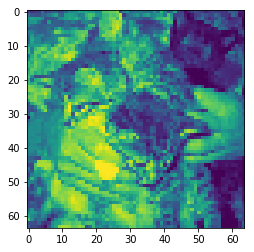

In [6]:
train_data = np.concatenate((train_data_loaded[500:], train_data_loaded[:-500]), axis=0)
plt.imshow(train_data[0])
train_labels = np.concatenate((train_labels_loaded[500:], train_labels_loaded[:-500]), axis=0)
print(train_labels[0])
#print(train_labels)

In [7]:
# Create the Estimator
dogs_vs_cats_classifier = tf.estimator.Estimator(
    model_fn=model_fn, model_dir="./tmp/" + MODEL_NAME)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/dogs-vs-cats-tensorflow-3.model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001CE09959080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)


In [ ]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
dogs_vs_cats_classifier.train(
    input_fn=train_input_fn,
    steps=3000,
    hooks=[logging_hook])
    


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/dogs-vs-cats-tensorflow-3.model\model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1201 into ./tmp/dogs-vs-cats-tensorflow-3.model\model.ckpt.
INFO:tensorflow:probabilities = [[0.5001719  0.4998281 ]
 [0.49888325 0.50111675]
 [0.49876067 0.5012393 ]
 [0.49930847 0.5006916 ]
 [0.49874768 0.5012523 ]
 [0.49896502 0.50103503]
 [0.5000607  0.49993935]
 [0.5014364  0.49856362]
 [0.49955976 0.50044024]
 [0.49876034 0.50123966]
 [0.4991849  0.5008151 ]
 [0.49835765 0.5016423 ]
 [0.49888197 0.501118  ]
 [0.49861684 0.5013831 ]
 [0.499021   0.500979  ]
 [0.4989573  0.50104266]
 [0.49918056 0.50081944]
 [0.50611365 0.49388632]
 [0.49759522 0.50240475]
 [0.49996144 0.50003856]
 [0.49828708 0.5017129 ]
 [0.4983062

INFO:tensorflow:probabilities = [[0.46163693 0.5383631 ]
 [0.46209782 0.5379022 ]
 [0.46520895 0.5347911 ]
 [0.46477297 0.53522706]
 [0.46295246 0.53704756]
 [0.4623052  0.53769475]
 [0.464284   0.53571606]
 [0.46389675 0.5361033 ]
 [0.45939782 0.5406022 ]
 [0.46334612 0.5366538 ]
 [0.46617702 0.533823  ]
 [0.46202764 0.53797233]
 [0.46422347 0.5357766 ]
 [0.46637824 0.5336217 ]
 [0.46214455 0.5378554 ]
 [0.4639633  0.53603673]
 [0.46285406 0.5371459 ]
 [0.46461904 0.535381  ]
 [0.46258676 0.5374132 ]
 [0.46338075 0.53661925]
 [0.46609977 0.53390026]
 [0.46299636 0.53700364]
 [0.4636703  0.5363297 ]
 [0.4610092  0.53899086]
 [0.4613056  0.5386944 ]
 [0.46001798 0.539982  ]
 [0.4634881  0.5365119 ]
 [0.46502578 0.53497416]
 [0.46338162 0.5366184 ]
 [0.4637582  0.5362418 ]
 [0.46098506 0.5390149 ]
 [0.46390972 0.5360903 ]
 [0.46704286 0.53295714]
 [0.46508208 0.53491795]
 [0.46535915 0.5346408 ]
 [0.47630402 0.52369595]
 [0.46590295 0.5340971 ]
 [0.4642373  0.5357627 ]
 [0.46409386 0.535

INFO:tensorflow:loss = 0.6674105, step = 1501 (158.052 sec)
INFO:tensorflow:probabilities = [[0.45965138 0.5403486 ]
 [0.46005306 0.5399469 ]
 [0.4569424  0.5430576 ]
 [0.4609027  0.53909737]
 [0.4593172  0.5406828 ]
 [0.45781612 0.5421839 ]
 [0.45847446 0.54152554]
 [0.45818883 0.54181117]
 [0.4780349  0.52196515]
 [0.4603906  0.5396094 ]
 [0.45789334 0.5421067 ]
 [0.4614144  0.5385856 ]
 [0.4586263  0.54137367]
 [0.45815018 0.54184973]
 [0.46037725 0.5396228 ]
 [0.46000502 0.539995  ]
 [0.4590414  0.54095864]
 [0.45835504 0.54164493]
 [0.4965285  0.5034715 ]
 [0.4601573  0.5398428 ]
 [0.4620406  0.53795946]
 [0.46012253 0.5398775 ]
 [0.4618384  0.5381616 ]
 [0.47232074 0.5276792 ]
 [0.46061188 0.5393882 ]
 [0.46245024 0.53754973]
 [0.4597223  0.5402777 ]
 [0.45588484 0.5441151 ]
 [0.4572813  0.5427187 ]
 [0.46165228 0.5383477 ]
 [0.46349955 0.53650045]
 [0.45969027 0.5403097 ]
 [0.45789412 0.5421059 ]
 [0.46123183 0.5387682 ]
 [0.46181923 0.53818077]
 [0.4605189  0.53948116]
 [0.4602

INFO:tensorflow:loss = 0.72696906, step = 1701 (152.071 sec)
INFO:tensorflow:probabilities = [[0.4869632  0.5130367 ]
 [0.5497709  0.45022908]
 [0.48581913 0.5141809 ]
 [0.48558939 0.5144106 ]
 [0.5047147  0.4952852 ]
 [0.485267   0.51473296]
 [0.5148408  0.48515916]
 [0.48672095 0.513279  ]
 [0.48938027 0.5106198 ]
 [0.48523727 0.5147627 ]
 [0.48569408 0.5143059 ]
 [0.4866293  0.51337063]
 [0.48716676 0.51283324]
 [0.48574945 0.5142505 ]
 [0.48591986 0.51408017]
 [0.485319   0.514681  ]
 [0.4847136  0.5152864 ]
 [0.48626134 0.51373863]
 [0.48611203 0.513888  ]
 [0.48703066 0.5129693 ]
 [0.48586065 0.5141394 ]
 [0.48741943 0.5125805 ]
 [0.48572317 0.51427674]
 [0.48644105 0.5135589 ]
 [0.48597744 0.5140226 ]
 [0.48730442 0.5126956 ]
 [0.48288912 0.5171109 ]
 [0.48658362 0.5134164 ]
 [0.48695073 0.51304924]
 [0.48657352 0.51342654]
 [0.48705322 0.5129467 ]
 [0.48436448 0.5156355 ]
 [0.48551065 0.51448935]
 [0.4854515  0.51454854]
 [0.49081245 0.5091875 ]
 [0.48520967 0.5147903 ]
 [0.490

INFO:tensorflow:loss = 0.6816805, step = 1901 (147.091 sec)
INFO:tensorflow:probabilities = [[0.50390285 0.49609715]
 [0.50268245 0.49731758]
 [0.51585394 0.48414603]
 [0.50279963 0.49720046]
 [0.50664324 0.49335673]
 [0.5044398  0.49556023]
 [0.5039406  0.49605945]
 [0.50486153 0.49513844]
 [0.5030356  0.49696434]
 [0.50371563 0.49628434]
 [0.50233483 0.4976652 ]
 [0.5031522  0.49684775]
 [0.5032744  0.4967256 ]
 [0.5036413  0.49635875]
 [0.5037216  0.49627843]
 [0.52263874 0.4773613 ]
 [0.50270563 0.49729437]
 [0.50385225 0.4961477 ]
 [0.50349516 0.49650484]
 [0.54017586 0.45982414]
 [0.5025393  0.4974607 ]
 [0.5040494  0.49595064]
 [0.5041146  0.49588528]
 [0.50288826 0.49711177]
 [0.67681134 0.32318863]
 [0.5034541  0.496546  ]
 [0.50369817 0.49630183]
 [0.5055605  0.49443945]
 [0.5149226  0.48507738]
 [0.5011533  0.4988467 ]
 [0.5027948  0.49720523]
 [0.5033874  0.4966126 ]
 [0.50410855 0.4958915 ]
 [0.50357604 0.49642393]
 [0.50468963 0.49531037]
 [0.5034642  0.4965358 ]
 [0.5037

In [34]:
#eval_data, eval_labels =  loadImages(False)

[[170. 176. 183. ... 216. 211. 206.]
 [170. 176. 183. ... 218. 214. 209.]
 [170. 176. 183. ... 218. 217. 212.]
 ...
 [130. 134. 137. ...   3.   3.   2.]
 [128. 130. 133. ...   3.   3.   2.]
 [125. 129. 132. ...   2.   2.   2.]]
1


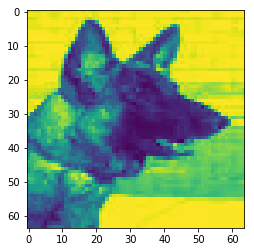

In [16]:
print(eval_data[0])
print(eval_labels[-1])
plt.imshow(eval_data[-1])

0


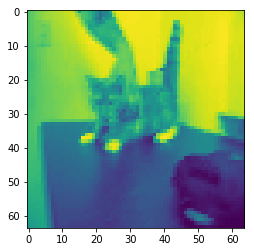

In [90]:
plt.imshow(eval_data[0])
print(eval_labels[0])

In [17]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = dogs_vs_cats_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)



INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-01-18:20:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/dogs-vs-cats-tensorflow-3.model\model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-01-18:20:53
INFO:tensorflow:Saving dict for global step 1200: accuracy = 0.519, global_step = 1200, loss = 0.692568
{'accuracy': 0.519, 'loss': 0.692568, 'global_step': 1200}


In [11]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=None,
    batch_size=128,
    num_epochs=1,
    shuffle=False,
)


predict_results = dogs_vs_cats_classifier.predict(input_fn=predict_input_fn)

## Premate Estimators

https://www.tensorflow.org/get_started/premade_estimators#create_input_functions

In [13]:

expected = eval_labels
template = ('\nPrediction is "{}" ({:.1f}%), expected "{}"')

for pred_dict, expec in zip(predict_results, expected):
    class_id = pred_dict['classes']
    probability = pred_dict['probabilities'][class_id]

    print(template.format(expected[class_id],
                          100 * probability, expec))



Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (54.3%), expected "0"

Prediction is "0" (52.8%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (55.5%), expected "0"

Prediction is "0" (61.7%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "


Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (52.4%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (51.5%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.8%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (50.6%), expected "0"

Prediction is "0" (52.4%), expected "0"

Prediction is "


Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (57.4%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (58.2%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (56.9%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (57.9%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "


Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (51.2%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "0" (50.6%), expected "1"

Prediction is "